<a href="https://colab.research.google.com/github/nbeaudoin/PyTorch-marathon/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network classification with PyTorch

Tutorial source: https://www.youtube.com/watch?v=V_xro1bcAuA&t=24452s

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1,000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# make a Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                         "X2": X[:, 1],
                         "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


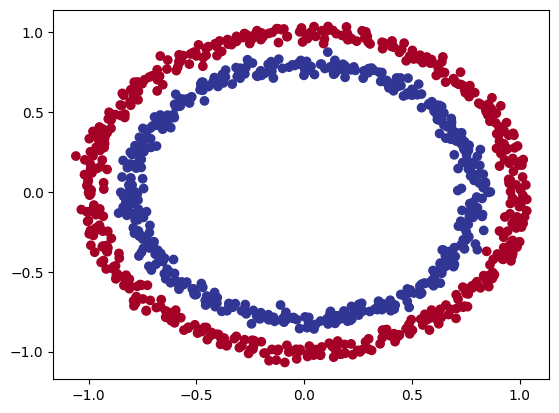

In [6]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check inputs and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Values for one sample of y: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Values for one sample of y: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'2.1.0+cu118'

In [11]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [16]:
n_samples

1000

## 2. Building a model

Let's build a model to classify the blue and red dots

To do so, we want to:
1. Setup device agnostic code so our code wil run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [17]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:
1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation)
4. Instantiate an instance of our model class and send it to our target `device`

In [18]:
X_train.shape

torch.Size([800, 2])

In [19]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [20]:
# 1. Construct a model that subclassess nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers for shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) ## takes in 2 features and upscales 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) ## takes in 5 features from previous layer and outputs a single layer

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) ## x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0



CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
device

'cuda'

In [22]:
# Put the model on GPU
next(model_0.parameters()).device

device(type='cuda', index=0)

In [23]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` implements most of the the Neural Network for you. When you have more complex operations it is important to know how to build your own subclass. The subclass can extend to handl emuch more complexity.

In [24]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6870, -0.0109],
                      [ 0.3869,  0.5176],
                      [ 0.7008,  0.0967],
                      [-0.3276, -0.6106],
                      [-0.0707, -0.5735]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0228,  0.0534,  0.4644, -0.1131, -0.5902], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0376,  0.0313,  0.0973, -0.4165,  0.3958]], device='cuda:0')),
             ('1.bias', tensor([0.1273], device='cuda:0'))])

The optimizer is going to change these parameters after backprop to get a better approximation

In [25]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device)) ## remember to move it to GPU

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10].round()}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

For example, for regression you might want MAE and MSE

For classification, you might want binary cross entropy or categorical cross entropy

As a reminder, the loss fucntion measures how *wrong* your predictions are

* For the loss function we're going to use `torch.nn.BCEwithLogitsLoss()`


In [26]:
# Setup the loss function
#loss_fn = nn.BCEWithLogitsLoss  ## BCELoss = requires inputs to have gone through the sigmoid activation function
nn.Sequential(
    nn.Sigmoid(),
    nn.BCELoss()
)
loss_fn = nn.BCEWithLogitsLoss() ## sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [27]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6870, -0.0109],
                      [ 0.3869,  0.5176],
                      [ 0.7008,  0.0967],
                      [-0.3276, -0.6106],
                      [-0.0707, -0.5735]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0228,  0.0534,  0.4644, -0.1131, -0.5902], device='cuda:0')),
             ('1.weight',
              tensor([[-0.0376,  0.0313,  0.0973, -0.4165,  0.3958]], device='cuda:0')),
             ('1.bias', tensor([0.1273], device='cuda:0'))])

In [28]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

Need to build a training loop.

1. Forward pass
2. Calculate loss
3. Optimize zero grad
4. Loss backward (backprop)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -? prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probs by passing them to some kind of activation function (eg, sigmoid classication and softmax for multiclass classification).

Then we can convert our model's predicted probs to prediction labels by rounding them or taking the `argmax()`

In [29]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0362],
        [ 0.0423],
        [-0.1427],
        [-0.0064],
        [ 0.0145]], device='cuda:0')

In [30]:
y_test[:5]
## This is not the same format as ^^^

tensor([1., 0., 1., 0., 1.])

In [31]:
# Use the sigmoid act function on our model logits to turn into pred probs
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4910],
        [0.5106],
        [0.4644],
        [0.4984],
        [0.5036]], device='cuda:0')

For our prediction probability values, we need to perform a range-style ounding on them.

* y_pred_probs >= 0.5, `y=1` (class 1)
* y_pred_probs < 0.5, `y=0` (class 0)

In [32]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 1., 0., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epochs
epochs = 100

# Put the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) ## turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), ## n.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits, ## nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. loss.backward()
  loss.backward()

  #5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. Cacluate test loss/accuracy
    test_loss = loss_fn(test_logits,
                         y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69400, Acc: 49.75% | Test loss: 0.69744, Test accc: 49.50%
Epoch: 10 | Loss: 0.69374, Acc: 49.88% | Test loss: 0.69682, Test accc: 49.00%
Epoch: 20 | Loss: 0.69355, Acc: 49.75% | Test loss: 0.69634, Test accc: 49.00%
Epoch: 30 | Loss: 0.69341, Acc: 50.12% | Test loss: 0.69597, Test accc: 48.50%
Epoch: 40 | Loss: 0.69331, Acc: 50.00% | Test loss: 0.69567, Test accc: 50.00%
Epoch: 50 | Loss: 0.69323, Acc: 50.00% | Test loss: 0.69544, Test accc: 49.00%
Epoch: 60 | Loss: 0.69317, Acc: 49.88% | Test loss: 0.69526, Test accc: 48.00%
Epoch: 70 | Loss: 0.69313, Acc: 50.25% | Test loss: 0.69512, Test accc: 47.50%
Epoch: 80 | Loss: 0.69310, Acc: 50.12% | Test loss: 0.69500, Test accc: 48.00%
Epoch: 90 | Loss: 0.69307, Acc: 50.25% | Test loss: 0.69491, Test accc: 49.00%


## 4. Make predictions and evaluate the model

From the metrics, it looks like our model isn't learning anything

In [34]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

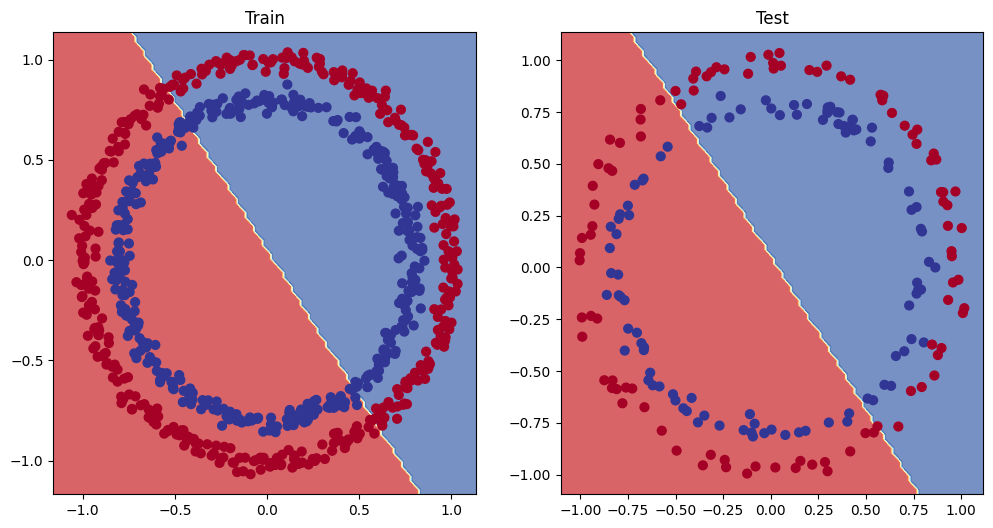

In [35]:
import numpy as np
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving the model (from a model perspective)

* Add more layers
* Add more hidden units
* Fit for longer
* Changnig the activation functions
* Change the learning rate
* Change the loss function

These options are all from our model's perspective because they deal directly with the model rather than the data.

Let's try making a better model!
* Add more hidden units
* Increase number of layers
* Increase epochs

In [36]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) ## this way levearges more speedups

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
# Create the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [38]:
# Write a training and evaliation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> predictions

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards (backprop)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate the loss
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 48.00%
Epoch: 100 | Loss: 0.69369, Acc: 50.25 | Test loss: 0.69269, Test acc: 48.00%
Epoch: 200 | Loss: 0.69351, Acc: 50.12 | Test loss: 0.69282, Test acc: 48.00%
Epoch: 300 | Loss: 0.69339, Acc: 50.50 | Test loss: 0.69295, Test acc: 48.00%
Epoch: 400 | Loss: 0.69329, Acc: 50.38 | Test loss: 0.69309, Test acc: 48.00%
Epoch: 500 | Loss: 0.69322, Acc: 49.88 | Test loss: 0.69322, Test acc: 48.00%
Epoch: 600 | Loss: 0.69317, Acc: 49.50 | Test loss: 0.69335, Test acc: 48.00%
Epoch: 700 | Loss: 0.69313, Acc: 49.38 | Test loss: 0.69347, Test acc: 48.00%
Epoch: 800 | Loss: 0.69309, Acc: 50.00 | Test loss: 0.69358, Test acc: 48.00%
Epoch: 900 | Loss: 0.69307, Acc: 50.62 | Test loss: 0.69368, Test acc: 48.00%


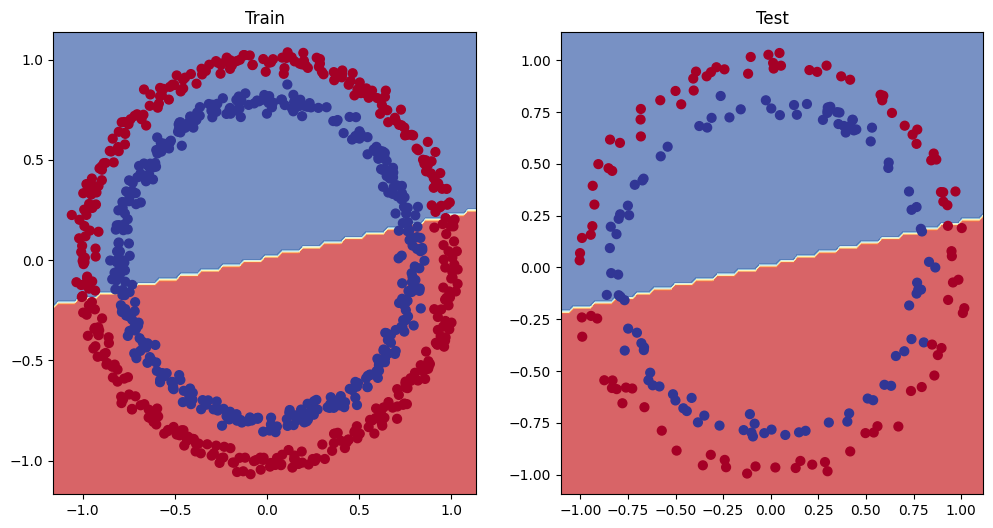

In [39]:
# Plot the decision boundary
import numpy as np
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparing the data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [43]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias ## linear regression formula without epsilon

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [44]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [45]:
# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

In [48]:
### Visualize!

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training_data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    # Plot preds if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label=predictions)

    # SHow the legned
    plt.legend(prop={"size": 14});

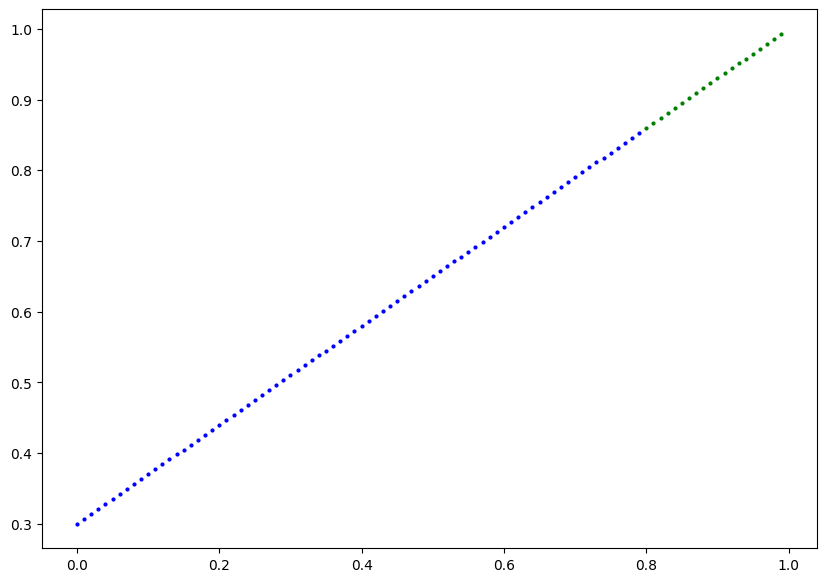

In [50]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [52]:
X_train_regression[0], y_train_regression[0]

(tensor([0.]), tensor([0.3000]))

In [53]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [55]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [59]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regeression)

  ## 11:42 ##